In [2]:
## Part 1 Code (CIFAR-10 + DenseNet-121)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np


In [3]:
# Dataset & Transforms

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 170M/170M [00:18<00:00, 9.08MB/s]


In [6]:
# Model Setup (Feature Extraction)

In [7]:
model = models.densenet121(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

num_features = model.classifier.in_features

model.classifier = nn.Sequential(
    nn.BatchNorm1d(num_features),
    nn.Dropout(0.5),
    nn.Linear(num_features, 10)
)

model = model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 83.4MB/s]


In [8]:
# Training Loop with Early Stopping

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)

train_losses, val_losses = [], []
best_val_loss = float("inf")
patience, counter = 5, 0

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            val_loss += criterion(model(x), y).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter == patience:
            print("Early stopping triggered")
            break


Epoch 1 | Train Loss: 0.6261 | Val Loss: 0.4723
Epoch 2 | Train Loss: 0.6106 | Val Loss: 0.4570
Epoch 3 | Train Loss: 0.6074 | Val Loss: 0.4627
Epoch 4 | Train Loss: 0.6008 | Val Loss: 0.4606
Epoch 5 | Train Loss: 0.6034 | Val Loss: 0.4556
Epoch 6 | Train Loss: 0.5978 | Val Loss: 0.4462
Epoch 7 | Train Loss: 0.5988 | Val Loss: 0.4578
Epoch 8 | Train Loss: 0.5856 | Val Loss: 0.4472
Epoch 9 | Train Loss: 0.5833 | Val Loss: 0.4463
Epoch 10 | Train Loss: 0.5855 | Val Loss: 0.4446


In [11]:
# Loss Curves

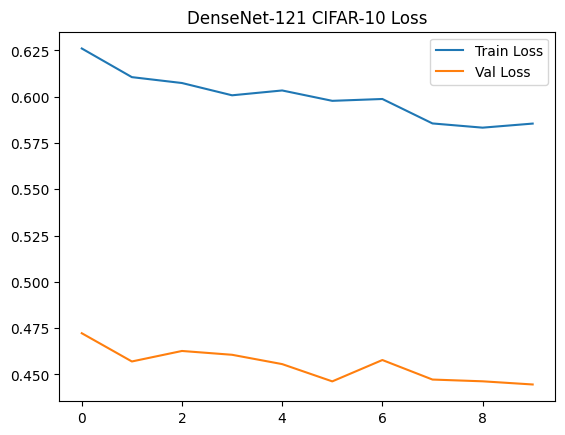

In [12]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("DenseNet-121 CIFAR-10 Loss")
plt.show()


In [13]:
# Test Accuracy & Confusion Matrix

Test Accuracy: 0.8368


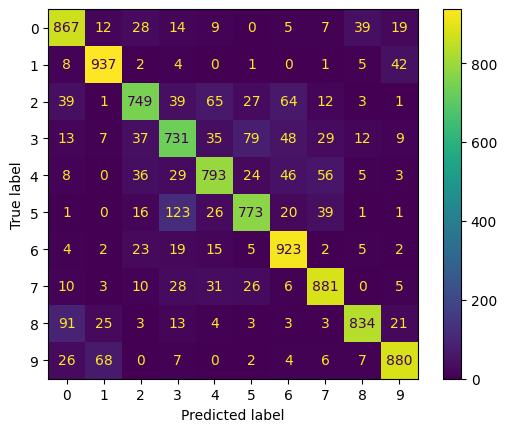

In [14]:
model.eval()
correct, total = 0, 0
preds, labels = [], []

with torch.no_grad():
    for x,y in test_loader:
        x,y = x.to(device), y.to(device)
        out = model(x)
        p = out.argmax(1)
        preds.extend(p.cpu().numpy())
        labels.extend(y.cpu().numpy())
        correct += (p == y).sum().item()
        total += y.size(0)

print("Test Accuracy:", correct / total)

cm = confusion_matrix(labels, preds)
ConfusionMatrixDisplay(cm).plot()
plt.show()


In [15]:
# Part 2 Code (MNIST)

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_size = int(0.8 * len(mnist_train))
val_size = len(mnist_train) - train_size
train_ds, val_ds = random_split(mnist_train, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.65MB/s]


In [17]:
# DNN Model

In [18]:
class MNIST_DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.net(x.view(x.size(0), -1))

model = MNIST_DNN().to(device)


In [19]:
# Training

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses, val_losses = [], []

for epoch in range(10):
    model.train()
    loss_sum = 0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()

    train_losses.append(loss_sum / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            val_loss += criterion(model(x), y).item()

    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")


Epoch 1 | Train Loss: 0.1564 | Val Loss: 0.1048
Epoch 2 | Train Loss: 0.1060 | Val Loss: 0.0873
Epoch 3 | Train Loss: 0.0849 | Val Loss: 0.0901
Epoch 4 | Train Loss: 0.0722 | Val Loss: 0.0764
Epoch 5 | Train Loss: 0.0586 | Val Loss: 0.0800
Epoch 6 | Train Loss: 0.0531 | Val Loss: 0.0776
Epoch 7 | Train Loss: 0.0468 | Val Loss: 0.0717
Epoch 8 | Train Loss: 0.0449 | Val Loss: 0.0733
Epoch 9 | Train Loss: 0.0398 | Val Loss: 0.0703
Epoch 10 | Train Loss: 0.0349 | Val Loss: 0.0649


In [22]:
# MNIST Evaluation

MNIST Test Accuracy: 0.9806


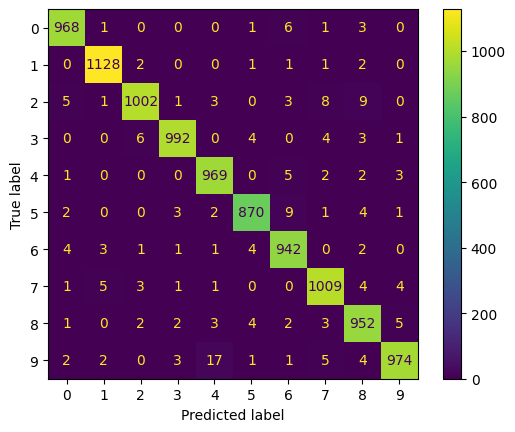

In [23]:
correct, total = 0, 0
preds, labels = [], []

with torch.no_grad():
    for x,y in test_loader:
        x,y = x.to(device), y.to(device)
        p = model(x).argmax(1)
        preds.extend(p.cpu().numpy())
        labels.extend(y.cpu().numpy())
        correct += (p == y).sum().item()
        total += y.size(0)

print("MNIST Test Accuracy:", correct / total)

cm = confusion_matrix(labels, preds)
ConfusionMatrixDisplay(cm).plot()
plt.show()
